In [26]:
%matplotlib inline
import emcee
import pymaster as nmt
import camb
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
import os
from getdist import plots, MCSamples
from contextlib import contextmanager
import corner
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [2]:
def corr(mat):
    sha = mat.shape
    corr_mat = np.zeros(sha)
    for i in range(sha[0]):
        for j in range(sha[1]):
            corr_mat[i,j] = mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])      
    return corr_mat
def plot_corr(mat):
    plt.imshow(corr(mat))
    plt.colorbar()

def get_beam(beam,lmax):
    fwhm = hp.gauss_beam(np.radians(beam/60.),lmax,True)[:,2]
    return fwhm
    
def get_noise(level,lmax):
    return np.ones(lmax+1) * (np.radians(level/60)**2)

In [3]:
rs = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD_old/LiteBird/RS/Pseudo_1024/C_l'
gs = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD_old/LiteBird/GS/Pseudo_1024/C_l'
camb_ini = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD_old/CAMB/CAMB.ini'

# COSMOLOGY
### Theoretical Spectra from CAMB

In [4]:
pars = camb.read_ini(camb_ini)
results = camb.get_results(pars)
scalar_powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [5]:
pars.WantTensors = True 
pars.InitPower.set_params(r=1)
results = camb.get_results(pars)
tensor_powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [6]:
lensed_th = scalar_powers['lensed_scalar'].T[2]
tensor_th = tensor_powers['tensor'].T[2]
assert len(lensed_th) == len(tensor_th)
L = np.arange(len(lensed_th))
DL_factor = L*(L+1)/(2*np.pi)

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(2, 9107.404212425137)

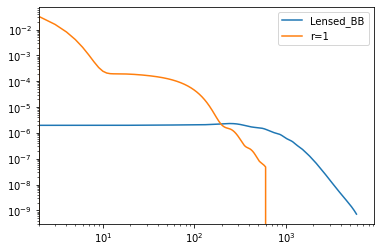

In [27]:
plt.loglog(L,lensed_th/DL_factor,label="Lensed_BB")
plt.loglog(L,tensor_th/DL_factor,label="r=1")
plt.legend()
plt.xlim(2,None)

# Setting $\ell$ ranges 

In [33]:
b = nmt.NmtBin.from_nside_linear(512, 10)
elll = b.get_effective_ells()

In [209]:
lmin = 90
lmax = 150
select = np.where((elll>lmin) & (elll<lmax))[0]
ell = elll[select]

In [210]:
ell

array([ 96.5, 106.5, 116.5, 126.5, 136.5, 146.5])

In [211]:
dl_factor = ell*(ell+1)/(2*np.pi)

# Simulation Septra of Lensed and Delensed
### 'rs' means Realisation, 'gs' means Gaussian Simulation

In [212]:
rs_lensed = [pk.load(open(os.path.join(rs,f'sims_lensed_{i}.pkl'),'rb'))[3][select] for i in range(100)]
rs_delensed = [pk.load(open(os.path.join(rs,f'sims_delensed_p_eb_{i}.pkl'),'rb'))[3][select] for i in range(100)]

In [213]:
gs_lensed = [pk.load(open(os.path.join(gs,f'sims_lensed_{i}.pkl'),'rb'))[3][select] for i in range(100)]
gs_delensed = [pk.load(open(os.path.join(gs,f'sims_delensed_p_eb_{i}.pkl'),'rb'))[3][select] for i in range(100)]
bias = [gs_delensed[i]-gs_lensed[i] for i in range(100)]

# Mean and Covariance 

In [214]:
ncov = len(gs_lensed[0])

In [215]:
lensed_mean = np.zeros(ncov)
for i in range(100):
    lensed_mean += rs_lensed[i]
lensed_mean/=100

lensed_cov = np.zeros([ncov,ncov])
for i in range(100):
    spec = rs_lensed[i]
    lensed_cov += spec[None,:]*spec[:,None]
lensed_cov/=100
lensed_cov -= lensed_mean[None,:]*lensed_mean[:,None]

In [216]:
delensed_b_mean = np.zeros(ncov)
for i in range(100):
    delensed_b_mean += rs_delensed[i]
delensed_b_mean/=100

delensed_mean = np.zeros(ncov)
for i in range(100):
    delensed_mean += rs_delensed[i] - bias[i]
delensed_mean/=100

delensed_cov = np.zeros([ncov,ncov])
for i in range(100):
    spec = rs_delensed[i] - bias[i]
    delensed_cov += spec[None,:]*spec[:,None]
delensed_cov/=100
delensed_cov -= delensed_mean[None,:]*delensed_mean[:,None]

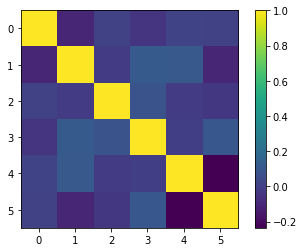

In [217]:
plot_corr(lensed_cov)

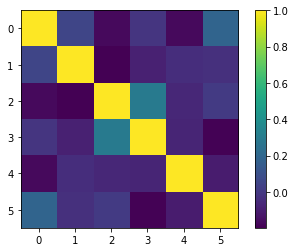

In [218]:
plot_corr(delensed_cov)

In [219]:
bl = get_beam(30,L[-1])
nl = get_noise(2.16,L[-1])

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(5e-07, 2.5915962380264367e-06)

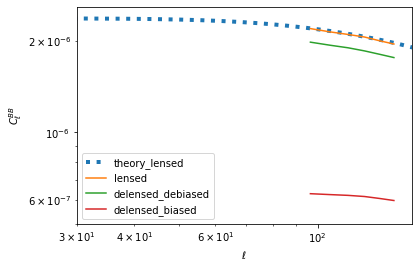

In [220]:
plt.loglog(L,(lensed_th/DL_factor)*bl**2 + nl,lw=4,ls=':',label="theory_lensed")
plt.loglog(ell,lensed_mean,label="lensed")
plt.loglog(ell,delensed_mean,label="delensed_debiased")
plt.loglog(ell,delensed_b_mean,label="delensed_biased")
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell^{BB}$")
plt.xlim(30,160)
plt.ylim(5e-7,None)

Text(0, 0.5, '$Var(C_\\ell^{BB})$')

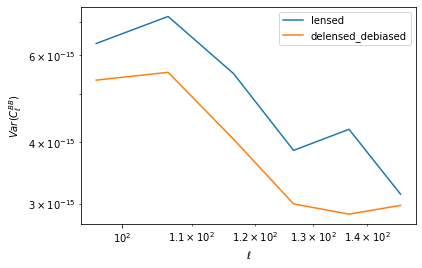

In [221]:
plt.loglog(ell,np.diag(lensed_cov),label="lensed")
plt.loglog(ell,np.diag(delensed_cov),label="delensed_debiased")
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("$Var(C_\ell^{BB})$")

# Likelihood
### This a base class mostly for common fuctions

In [222]:
class LH_base:
    
    def __init__(self,cov,nsample,lmin,lmax,fix_alens,ALENS,use_diag):
        self.tensor = tensor_th/DL_factor
        self.lensing = lensed_th/DL_factor
        self.b = b
        self.beam = get_beam(30,L[-1])
        self.noise = get_noise(2.16,L[-1])
        self.nsamples = nsample
        ell = b.get_effective_ells()
        self.select = np.where((ell>lmin) & (ell<lmax))[0]
        self.ell = ell[self.select]
        self.fix_alens = fix_alens
        
        if self.fix_alens:
            assert ALENS is not None
            self.Alens=ALENS
        
        if use_diag:
            cov_ = np.zeros(cov.shape)
            np.fill_diagonal(cov_, np.diag(cov))
        else:
            cov_ = cov
            
        self.cov_inv = np.linalg.inv(cov_) 
    
    def chi_sq(self):
        pass
    
    def cl_theory(self,r,Alens=None):
        if self.fix_alens:
            Alens = self.Alens
        
        th = (r * self.tensor) + (Alens * self.lensing)
        th = th*self.beam**2 + self.noise
        return self.b.bin_cell(th[:self.b.lmax+1])[self.select]

    def log_prior(self,theta):
        if self.fix_alens:
            r= theta
            if  -0.5 < r < 0.5:
                return 0.0
            return -np.inf
        else:
            r,Alens= theta
            if  -0.5 < r < 0.5 and -1 < Alens < 1.5:
                return 0.0
            return -np.inf

    def log_probability(self,theta,i):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp  -.5*self.chi_sq(theta,i)
    

    def posterior(self,i):
        if self.fix_alens:
            pos = np.array([0]) + 1e-4 * np.random.randn(100, 1)
        else:
            pos = np.array([0,.5]) + 1e-4 * np.random.randn(100, 2)
        nwalkers, ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.log_probability,kwargs={'i':i})
        sampler.run_mcmc(pos, self.nsamples,progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        return flat_samples
    
    def report(self,i):
        with suppress_stdout():
            if not self.fix_alens:
                samp = MCSamples(samples=i,names=['r','alens'], labels=['r','alens'])
                return (f"{samp.getInlineLatex('r',limit=1,err_sig_figs=5)}",
                        f"{samp.getInlineLatex('alens',limit=1,err_sig_figs=5)}")
            else:
                samp = MCSamples(samples=i,names=['r'], labels=['r'])
                return f"{samp.getInlineLatex('r',limit=1,err_sig_figs=5)}"
    
    
    def plot_posterior(self,i):
        if self.fix_alens:
            labels = ["r"]
        else:
            labels = ["r","Alens"]
        flat_samples = self.posterior(i)
        print(self.report(flat_samples))
        plt.figure(figsize=(8,8))
        fig = corner.corner(flat_samples, labels=labels,truths=[0] if self.fix_alens else [0,0])

# Simple Likelihood

## $ \chi^2 = (C_\ell^{theory} - C_\ell^{data})^T . COV^{-1} (C_\ell^{theory} - C_\ell^{data}) $

In [223]:
class LH_simple(LH_base):

    def __init__(self,cov,nsample,lmin=30,lmax=150,fix_alens=False,ALENS=None,use_diag=False):
        super().__init__(cov,nsample,lmin,lmax,fix_alens,ALENS,use_diag)
    
    def vect(self,theta,i):
        if self.fix_alens:
            r = theta
            cl_th = self.cl_theory(r) 
        else:
            r, alens= theta
            cl_th = self.cl_theory(r, alens)  
        return cl_th - i
    
    def chi_sq(self,theta,i):
        vec = self.vect(theta,i)
        l = np.dot(np.dot(vec,self.cov_inv),vec)
        return  l

# Results: Lensed

# Note: Best fit ans Sigma_r is printed just above the figures

### Case-1
### Fix Alens = False
### Use only Diagonal of Covariance = False

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 118.51it/s]


('r = 0.0003803\\pm 0.0014946', 'alens = 0.988243\\pm 0.026872')


<Figure size 576x576 with 0 Axes>

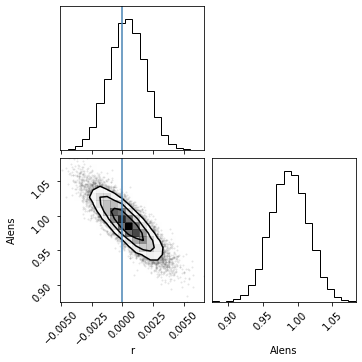

In [123]:
LH_simple(lensed_cov,2000,lmin,lmax,use_diag=False).plot_posterior(lensed_mean)

### Case-2
### Fix Alens = False
### Use only Diagonal of Covariance = True

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 118.16it/s]


('r = 0.0003086\\pm 0.0015276', 'alens = 0.989543\\pm 0.028252')


<Figure size 576x576 with 0 Axes>

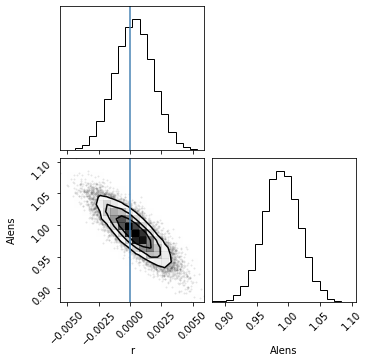

In [124]:
LH_simple(lensed_cov,2000,lmin,lmax,use_diag=True).plot_posterior(lensed_mean)

### Case-3
### Fix Alens = True
### Use only Diagonal of Covariance = False

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 121.57it/s]


r = -0.0003783\pm 0.0011683


<Figure size 576x576 with 0 Axes>

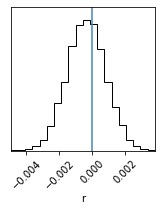

In [224]:
LH_simple(lensed_cov,2000,lmin,lmax,fix_alens=True,ALENS=1,use_diag=False).plot_posterior(lensed_mean)

### Case-4
### Fix Alens = True
### Use only Diagonal of Covariance = True

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 118.43it/s]


r = -0.0003343\pm 0.0012159


<Figure size 576x576 with 0 Axes>

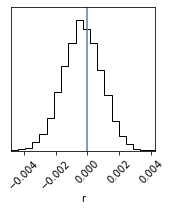

In [225]:
LH_simple(lensed_cov,2000,lmin,lmax,fix_alens=True,ALENS=1,use_diag=True).plot_posterior(lensed_mean)

# Result: Delensed

### Case-1
### Fix Alens = False
### Use only Diagonal of Covariance = False

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 117.86it/s]


('r = 0.0003831\\pm 0.0012598', 'alens = 0.868132\\pm 0.023273')


<Figure size 576x576 with 0 Axes>

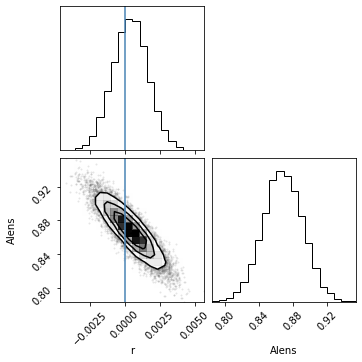

In [127]:
LH_simple(delensed_cov,2000,lmin,lmax,use_diag=False).plot_posterior(delensed_mean)

### Case-2
### Fix Alens = False
### Use only Diagonal of Covariance = True

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:17<00:00, 116.19it/s]


('r = 0.0003754\\pm 0.0013249', 'alens = 0.868222\\pm 0.025135')


<Figure size 576x576 with 0 Axes>

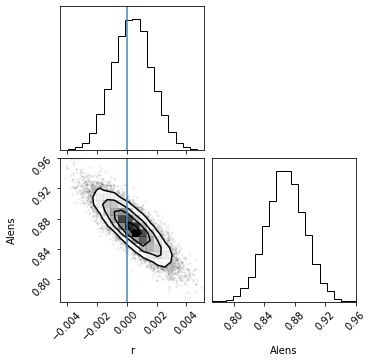

In [128]:
LH_simple(delensed_cov,2000,lmin,lmax,use_diag=True).plot_posterior(delensed_mean)

### Case-3
### Fix Alens = True
### Use only Diagonal of Covariance = False

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 120.89it/s]


r = -0.00032412\pm 0.00097746


<Figure size 576x576 with 0 Axes>

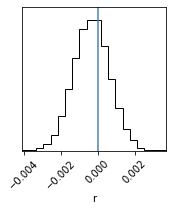

In [226]:
LH_simple(delensed_cov,2000,lmin,lmax,fix_alens=True,ALENS=.88,use_diag=False).plot_posterior(delensed_mean)

### Case-4
### Fix Alens = True
### Use only Diagonal of Covariance = True

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:16<00:00, 124.36it/s]


r = -0.0003162\pm 0.0010811


<Figure size 576x576 with 0 Axes>

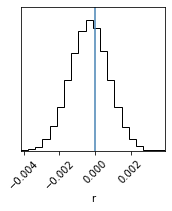

In [227]:
LH_simple(delensed_cov,2000,lmin,lmax,fix_alens=True,ALENS=.88,use_diag=True).plot_posterior(delensed_mean)

# Spectra Difference(Delensed - Lensed)

In [131]:
sd_mean = np.zeros(ncov)
for i in range(100):
    sd_mean += rs_delensed[i] - bias[i] - rs_lensed[i] 
sd_mean/=100

sd_cov = np.zeros([ncov,ncov])
for i in range(100):
    spec = rs_delensed[i] - bias[i] - rs_lensed[i]
    sd_cov += spec[None,:]*spec[:,None]
sd_cov/=100
sd_cov -= sd_mean[None,:]*sd_mean[:,None]

# Likelihood

In [132]:
class LH_df(LH_simple):
    def __init__(self,cov,nsample,lmin=30,lmax=150,fix_alens=False,ALENS=None,use_diag=False):
        super().__init__(cov,nsample,lmin,lmax,fix_alens,ALENS,use_diag)
        
        
    def cl_theory(self,r,Alens=None):
        if self.fix_alens:
            Alens = self.Alens
        th_len = self.lensing*self.beam**2 + self.noise
        th_del = ((r * self.tensor) + (Alens * self.lensing))*self.beam**2 + self.noise
        th = th_del - th_len
        return self.b.bin_cell(th[:self.b.lmax+1])[self.select]

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:22<00:00, 87.33it/s]


('r = 0.0000168\\pm 0.0017215', 'alens = 0.878645\\pm 0.032469')


<Figure size 576x576 with 0 Axes>

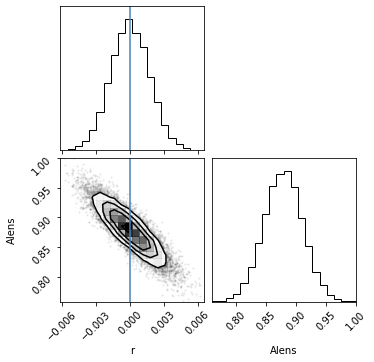

In [134]:
LH_df(sd_cov,2000,lmin,lmax).plot_posterior(sd_mean)

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:22<00:00, 88.03it/s]


r = -0.00001321\pm 0.00084830


<Figure size 576x576 with 0 Axes>

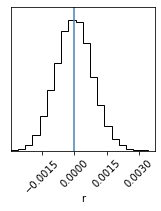

In [135]:
LH_df(sd_cov,2000,lmin,lmax,fix_alens=True,ALENS=.88).plot_posterior(sd_mean)

In [153]:
de_m = np.zeros(ncov)
for i in range(100):
    de_m += .9*rs_lensed[i]
de_m/=100

de_cov = np.zeros([ncov,ncov])
for i in range(100):
    spec = .9*rs_lensed[i]
    de_cov += spec[None,:]*spec[:,None]
de_cov/=100
de_cov -= de_m[None,:]*de_m[:,None]

/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/global/homes/l/lonappan/.conda/envs/PC2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
100%|██████████| 2000/2000 [00:17<00:00, 117.22it/s]


r = -0.00025878\pm 0.00075427


<Figure size 576x576 with 0 Axes>

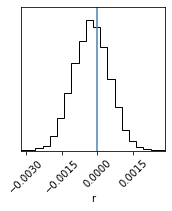

In [138]:
LH_simple(de_cov,2000,lmin,lmax,fix_alens=True,ALENS=.88,use_diag=True).plot_posterior(de_m)

Text(0, 0.5, '$Var(C_\\ell^{BB})$')

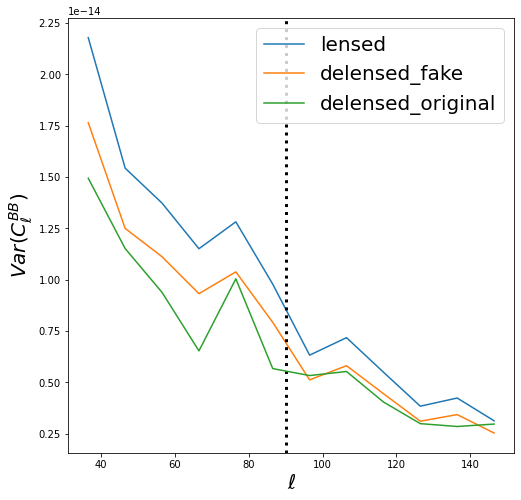

In [192]:
plt.figure(figsize=(8,8))
plt.plot(ell,np.diag(lensed_cov),label="lensed")
plt.plot(ell,np.diag(de_cov),label="delensed_fake")
plt.axvline(90,ls=":",lw=3,c='k')
plt.plot(ell,np.diag(delensed_cov),label="delensed_original")
plt.legend(fontsize=20)
plt.xlabel("$\ell$",fontsize=20)
plt.ylabel("$Var(C_\ell^{BB})$",fontsize=20)

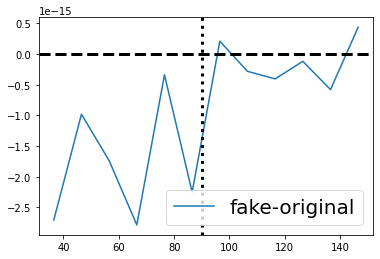

In [194]:
plt.plot(ell,np.diag(delensed_cov)-np.diag(de_cov),label='fake-original')
plt.axhline(0,c='k',ls='--',lw=3)
plt.axvline(90,ls=":",lw=3,c='k')
plt.legend(fontsize=20,loc='lower right')

In [189]:
ell

array([ 36.5,  46.5,  56.5,  66.5,  76.5,  86.5,  96.5, 106.5, 116.5,
       126.5, 136.5, 146.5])